### In this notebook you can see code for h5ad file preparation from raw data from https://hub.docker.com/r/jinmiaochenlab/batch-effect-removal-benchmarking.

In [1]:
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bbknn
from sklearn.metrics import silhouette_score
import time
import scanorama
import mnnpy


warnings.filterwarnings("ignore")

In [10]:
os.listdir("simulated_data/batch_effect/dataset4/")

['mySample_pancreatic_5batches.txt', 'myData_pancreatic_5batches.txt']

In [31]:
data_name = "myData_pancreatic_5batches.txt"
sample_name = "mySample_pancreatic_5batches.txt"
batch_name = "batchlb"
out_adata_name = "unfiltered_dataset4"
cell_type_name = "celltype"

In [21]:
data_dir = "simulated_data/batch_effect/dataset4/"
adata1 = pd.read_csv(os.path.join(data_dir, data_name), sep="\t", header=0, index_col=0)

In [22]:
adata = sc.AnnData(np.transpose(adata1))
print(adata)
print(adata.obs_names[1:3].values)
print(adata.var_names[1:3].values)

AnnData object with n_obs × n_vars = 14767 × 15558
['human1_lib1.final_cell_0002' 'human1_lib1.final_cell_0003']
['A1CF' 'A2M']


In [24]:
sample_adata = pd.read_csv(os.path.join(data_dir, sample_name), header=0, index_col=0, sep="\t")
print(sample_adata.values.shape)
print(sample_adata.keys().values)

(14767, 5)
['batch' 'batchlb' 'celltype_orig' 'cellname' 'celltype']


In [32]:
adata.obs["cell_type"] = sample_adata.loc[adata.obs_names, [cell_type_name]]
adata.obs["batch"] = sample_adata.loc[adata.obs_names, [batch_name]]

In [34]:
adata.write_h5ad(os.path.join(data_dir, f"{out_adata_name}.h5ad"))

PermissionError: [Errno 13] Unable to create file (unable to open file: name = 'simulated_data/batch_effect/dataset4/unfiltered_dataset4.h5ad', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 242)

In [2]:
adata = sc.read_h5ad("adata4.h5ad")
adata

AnnData object with n_obs × n_vars = 14767 × 15558
    obs: 'celltype', 'batchlb'

### Filtration

In [3]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
#sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


In [2]:
def umapplot(adata, color_by, n_pcs=20, save_file_prefix="umap", n_neighbors=10, use_repx=False):
    if use_repx:
        sc.pp.neighbors(adata, use_rep='X')
    else:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

    sc.tl.umap(adata)
    sc.pl.umap(adata, color=color_by, show=False)
    save_image(save_file_prefix)


def save_image(resname):
    if not os.path.exists("./visualization"):
        os.makedirs("./visualization")
    resname = f"./visualization/{resname}.png"
    plt.savefig(resname, dpi=100)
    

def tsneplot(adata, color_by, n_pcs=20, perplexity=90, save_file_prefix="tsne", use_repx=False):
    if use_repx:
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity, use_rep='X')
    else:
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity)
    sc.pl.tsne(adata, color=color_by, show=False, wspace=.3)
    save_image(save_file_prefix)

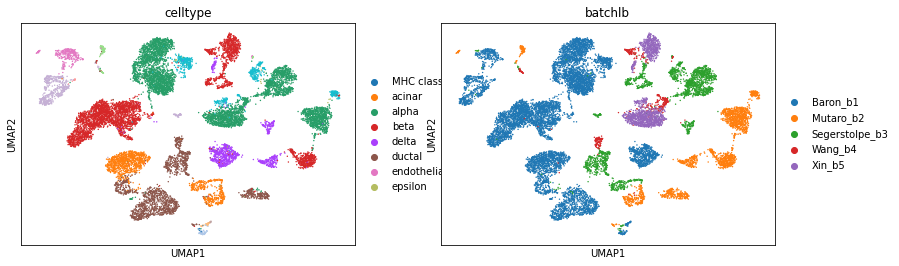

In [8]:
umapplot(adata, color_by=["celltype", "batchlb"])

### Correction with bbknn

In [6]:
adata_bbknn = bbknn.bbknn(adata, copy=True, neighbors_within_batch=5, trim=0, n_pcs=20, batch_key='batchlb')

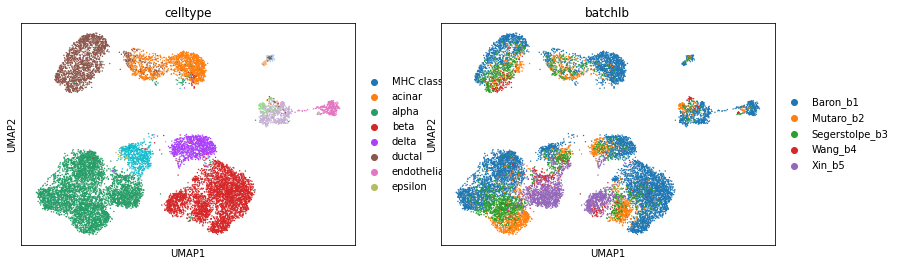

In [9]:
sc.tl.umap(adata_bbknn)
color_group = ["celltype", "batchlb"]
sc.pl.umap(adata_bbknn, color=color_group)

In [15]:
adata

AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
    uns: 'log1p', 'pca', 'celltype_colors', 'batchlb_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [2]:
adata_old = sc.read_h5ad("adata4.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
    uns: 'batchlb_colors', 'celltype_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
silhouette_score(adata.X, adata.obs["celltype"])

0.056663305

In [9]:
silhouette_score(adata_old.X, adata_old.obs["celltype"])

-0.73189354

### MNN correct

In [30]:
adata = sc.read_h5ad("adata4.h5ad")

In [31]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
#sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


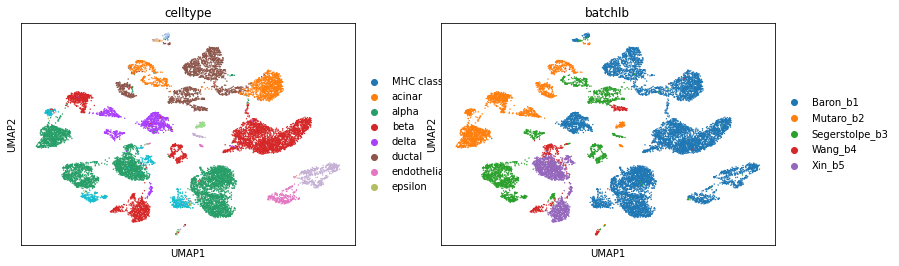

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
color_group = ["celltype", "batchlb"]
sc.pl.umap(adata, color=color_group)

In [36]:
adata_bbknn = bbknn.bbknn(adata, copy=True, neighbors_within_batch=5, trim=0, n_pcs=20, batch_key=args.batch)

In [44]:
adata_list = [adata[adata.obs['batchlb'] == i] for i in adata.obs['batchlb'].unique()]
hvgs = adata.var_names

In [45]:
corrected = mnnpy.mnn_correct(adata_list[0], adata_list[1], var_subset=hvgs)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


... storing 'celltype' as categorical
... storing 'batchlb' as categorical


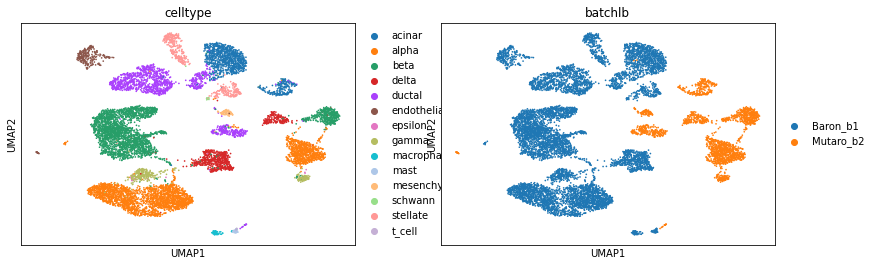

In [51]:
sc.pp.neighbors(corrected[0], n_neighbors=10, n_pcs=20)
sc.tl.umap(corrected[0])
color_group = ["celltype", "batchlb"]
sc.pl.umap(corrected[0], color=color_group)

In [52]:
silhouette_score(corrected[0].X, corrected[0].obs["celltype"])

0.0791119

### Regress out

In [69]:
adata = sc.read_h5ad("adata4.h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
#sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


In [70]:
sc.pp.combat(adata, "batchlb")

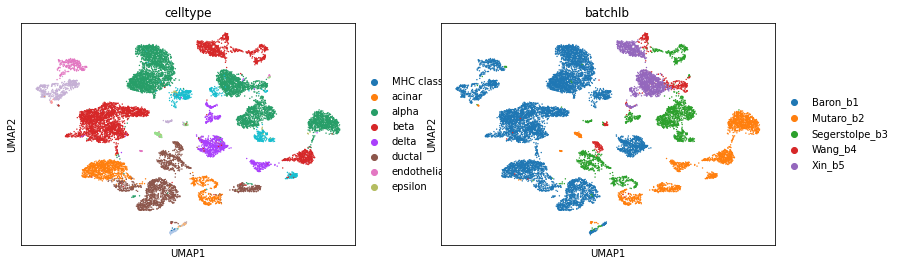

In [71]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
color_group = ["celltype", "batchlb"]
sc.pl.umap(adata, color=color_group)

In [60]:
silhouette_score(adata.X, adata.obs["celltype"])

0.059758275451826416

In [25]:
adata = sc.read_h5ad("adata4.h5ad")
#silhouette_score(adata.X, adata.obs["celltype"])

In [26]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# sc.tl.umap(adata)
# color_group = ["celltype", "batchlb"]
# sc.pl.umap(adata, color=color_group)

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


In [72]:
mnn_adata = sc.read_h5ad("mnn_adata4.h5ad")
mnn_adata

AnnData object with n_obs × n_vars = 10691 × 2237
    obs: 'celltype', 'batchlb', 'n_counts', 'batch'
    obsm: 'X_pca', 'X_umap'

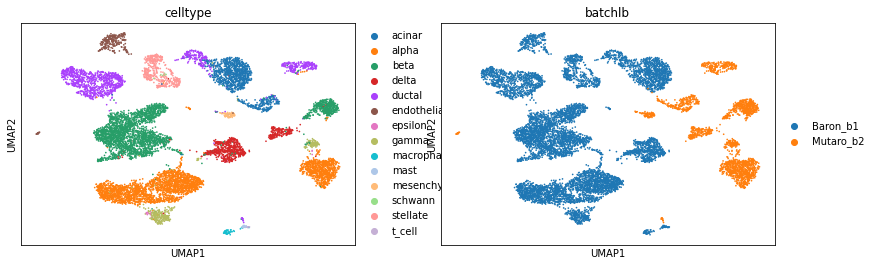

In [79]:
sc.pp.neighbors(mnn_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(mnn_adata)
sc.pl.umap(mnn_adata, color=color_group)

In [73]:
combat_adata = sc.read_h5ad("combat_adata4.h5ad")
combat_adata

AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
    uns: 'batchlb_colors', 'celltype_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

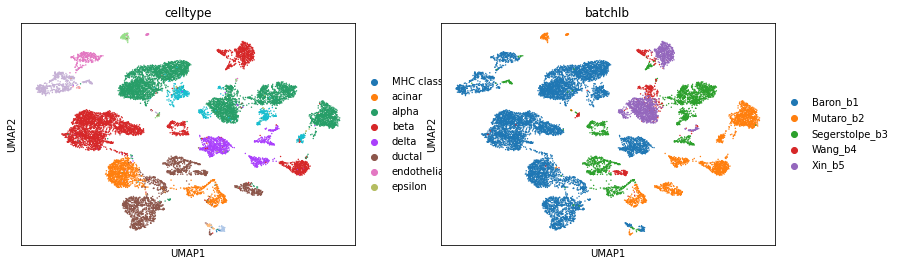

In [80]:
sc.pp.neighbors(combat_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(combat_adata)
sc.pl.umap(combat_adata, color=color_group)

In [84]:
bbknn_adata = sc.read_h5ad("bbknn_adata4.h5ad")
bbknn_adata

AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
    uns: 'batchlb_colors', 'celltype_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

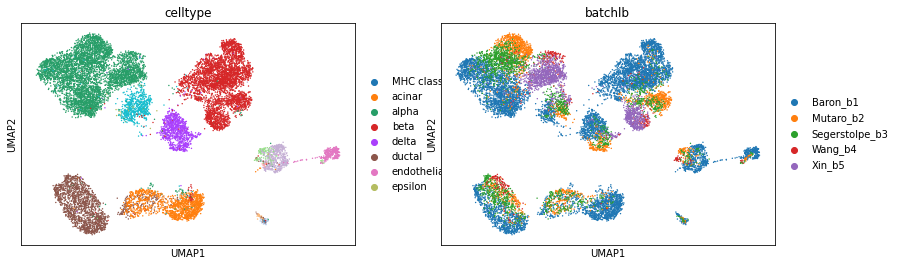

In [85]:
# sc.pp.neighbors(bbknn_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(bbknn_adata)
sc.pl.umap(bbknn_adata, color=color_group)

In [27]:
adata_scanorama = adata.copy()
adata_list = [adata_scanorama[adata_scanorama.obs['batchlb'] == i] for i in adata_scanorama.obs['batchlb'].unique()]
corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)


Found 2237 genes among all datasets
[[0.         0.23421301 0.31687823 0.01531729 0.03485255]
 [0.         0.         0.64278982 0.05908096 0.00377003]
 [0.         0.         0.         0.64113786 0.46849866]
 [0.         0.         0.         0.         0.46170678]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
Processing datasets (0, 2)
Processing datasets (0, 1)


In [28]:
corrected_merged_dge = corrected[0].concatenate(*corrected[1:])
corrected_merged_dge.obs = adata_scanorama.obs

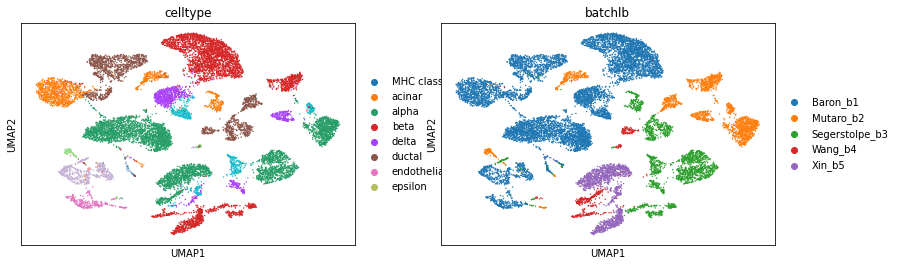

In [29]:
color_group = ["celltype", "batchlb"]
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10, n_pcs=20)
sc.tl.umap(corrected_merged_dge)
sc.pl.umap(corrected_merged_dge, color=color_group)

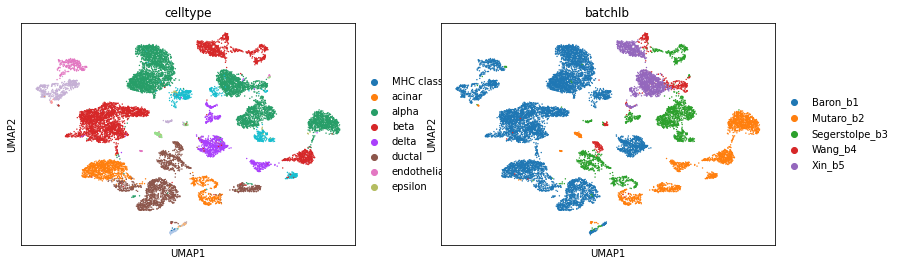

In [99]:
sc.pl.umap(adata, color=color_group)

In [7]:
silhouette_score(corrected_merged_dge.X, adata.obs["celltype"])

0.028647771

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


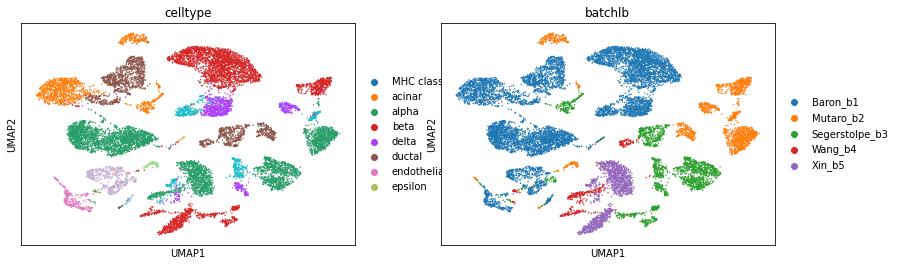

Found 2237 genes among all datasets
[[0.         0.23421301 0.31687823 0.01531729 0.03485255]
 [0.         0.         0.64278982 0.05908096 0.00377003]
 [0.         0.         0.         0.64113786 0.46849866]
 [0.         0.         0.         0.         0.46170678]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
Processing datasets (0, 2)
Processing datasets (0, 1)


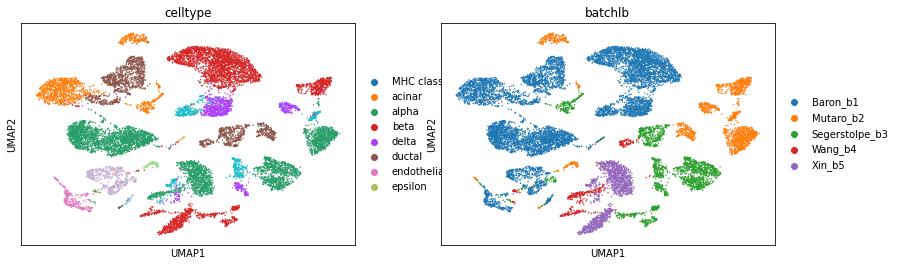

In [30]:
adata = sc.read_h5ad("adata4.h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
adata_scanorama = adata.copy()
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
color_group = ["celltype", "batchlb"]
sc.pl.umap(adata, color=color_group)

adata_list = [adata_scanorama[adata_scanorama.obs['batchlb'] == i] for i in adata_scanorama.obs['batchlb'].unique()]
corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)
corrected_merged_dge = corrected[0].concatenate(*corrected[1:])
corrected_merged_dge.obs = adata_scanorama.obs
color_group = ["celltype", "batchlb"]
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10, n_pcs=20)
sc.tl.umap(corrected_merged_dge)
sc.pl.umap(corrected_merged_dge, color=color_group)

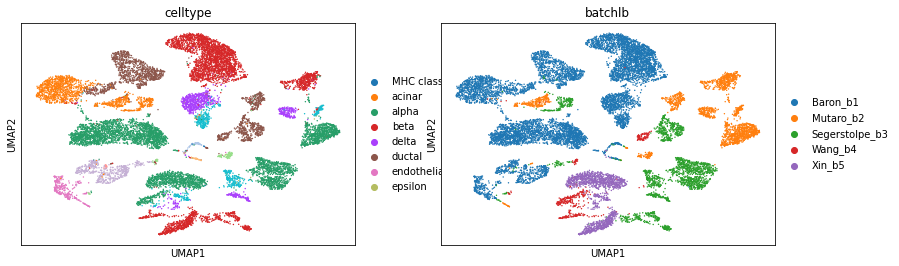

In [10]:
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10, n_pcs=20)
sc.tl.umap(corrected_merged_dge)
sc.pl.umap(corrected_merged_dge, color=color_group)

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
Found 2237 genes among all datasets
[[0.         0.23421301 0.31687823 0.01531729 0.03485255]
 [0.         0.         0.64278982 0.05908096 0.00377003]
 [0.         0.         0.         0.64113786 0.46849866]
 [0.         0.         0.         0.         0.46170678]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
Processing datasets (0, 2)
Processing datasets (0, 1)


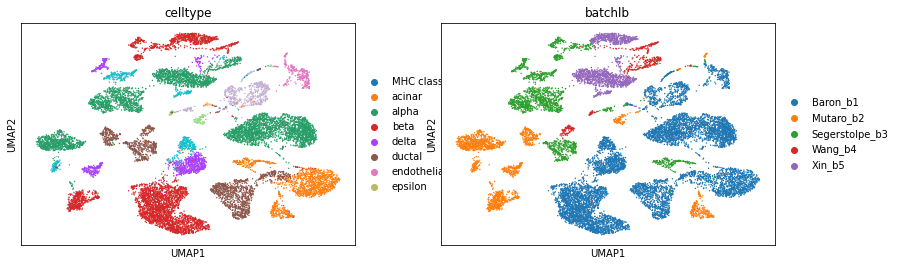

In [2]:
adata = sc.read_h5ad("adata4.h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
adata_scanorama = adata.copy()
adata_list = [adata_scanorama[adata_scanorama.obs['batchlb'] == i] for i in adata_scanorama.obs['batchlb'].unique()]
corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)
corrected_merged_dge = corrected[0].concatenate(*corrected[1:])
corrected_merged_dge.obs = adata_scanorama.obs
color_group = ["celltype", "batchlb"]
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10, n_pcs=20)
sc.tl.umap(corrected_merged_dge)
sc.pl.umap(corrected_merged_dge, color=color_group)

In [3]:
silhouette_score(corrected_merged_dge.X, adata.obs["celltype"])

0.032336123

In [2]:
scanorama_adata = sc.read_h5ad("adata4/scanorama_adata4.h5ad")
scanorama_adata

AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'
    uns: 'batchlb_colors', 'celltype_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
silhouette_score(scanosimulated_data/a_adata.X, scanorama_adata.obs["celltype"])

0.028647771

In [5]:
adata1 = pd.read_csv("simulated_data/batch_effect/dataset7/b1_exprs.txt",sep='\t',header=0, index_col=0)
adata2 = pd.read_csv("simulated_data/batch_effect/dataset7/b2_exprs.txt",sep='\t',header=0, index_col=0)
adata = pd.concat([adata1, adata2], axis=1)
adata = sc.AnnData(np.transpose(adata))
sample_adata1 = pd.read_csv("simulated_data/batch_effect/dataset7/b1_celltype.txt",header=0, index_col=0, sep='\t')
sample_adata1['batch'] = 'batch1'
sample_adata2 = pd.read_csv("simulated_data/batch_effect/dataset7/b2_celltype.txt",header=0, index_col=0, sep='\t')
sample_adata2['batch'] = 'batch2'
sample_adata = pd.concat([sample_adata1, sample_adata2], axis=0)
adata.obs['celltype'] = sample_adata.loc[adata.obs_names,['CellType']]
adata.obs['batchlb'] = sample_adata.loc[adata.obs_names,['batch']]
adata.write_h5ad("adata7.h5ad")

... storing 'celltype' as categorical
... storing 'batchlb' as categorical


In [ ]:
adata = sc.read_text(os.path.join(data_dir,'dataset1_sm_uc3.txt'),delimiter='\t',first_column_names=True,dtype='float64')
print(adata)
print(len(adata.obs_names))
print(adata.var_names)
Read sample into a pandas series
sample_adata = pd.read_csv(os.path.join(data_dir,'sample_sm_uc3.txt'),header=0, index_col=0, sep='\t')
print(sample_adata.values.shape)
print(sample_adata.keys())

Data have format genes x cells
But input for scanpy package require the format of cells x genes, samples x features
We need to copyt data into new adata object with inverse raw data 
adata1 = sc.AnnData(adata.X.T)
adata1.var_names = adata.obs_names
adata1.obs_names = adata.var_names
adata1
Save label information into adata object, same idea as Seurat 
adata1.obs['cell_type'] = sample_adata.loc[adata1.obs_names,['celltype']]
adata1.obs['batch'] = sample_adata.loc[adata1.obs_names,['batch']]
print(len(adata1.obs['cell_type']))
print(len(adata1.obs['batch']))
Save output into h5ad, easy to access 
adata1.write_h5ad(os.path.join(data_dir,'dataset1_uc3.h5ad'))

In [33]:
adata1 = sc.read_h5ad("adata1.h5ad")
adata1

AnnData object with n_obs × n_vars = 576 × 26593
    obs: 'celltype', 'batch'

In [34]:
adata4 = sc.read_h5ad("adata4.h5ad")
adata4

AnnData object with n_obs × n_vars = 14767 × 15558
    obs: 'celltype', 'batchlb'

In [6]:
adata7 = sc.read_h5ad("adata7/combat_adata7.h5ad")
adata7

AnnData object with n_obs × n_vars = 71638 × 3128
    obs: 'celltype', 'batchlb', 'n_counts'
    var: 'mean', 'std'
    uns: 'batchlb_colors', 'celltype_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
silhouette_score(adata7.X, adata7.obs["celltype"])

-0.002514385307536985

In [48]:
class BbknnCorrection:
    def __init__(self, adata, batch, celltype):
        self.adata = adata
        self.batch = batch
        self.celltype = celltype

    def filter(self):
        sc.pp.normalize_per_cell(self.adata, counts_per_cell_after=1e4)
        filter_result = sc.pp.filter_genes_dispersion(self.adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
        self.adata = self.adata[:, filter_result.gene_subset]
        sc.pp.log1p(self.adata)
        sc.pp.scale(self.adata, max_value=10)
        sc.tl.pca(self.adata, svd_solver='arpack')

    def correct(self):
        start = time.time()
        self.adata = bbknn.bbknn(self.adata, copy=True, neighbors_within_batch=5, trim=0, n_pcs=20, batch_key=self.batch)
        print(f"BBKNN has taken {time.time() - start} seconds")

In [37]:
adata1_bbknn = BbknnCorrection(adata4, "batchlb", "celltype")

In [38]:
adata1_bbknn.filter()
silhouette_score(adata1_bbknn.adata.X, adata1_bbknn.adata.obs[adata1_bbknn.batch])

-0.05022194

In [16]:
adata1_bbknn.adata

AnnData object with n_obs × n_vars = 576 × 6200
    obs: 'celltype', 'batch', 'n_counts'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [39]:
adata1_bbknn.correct()

BBKNN has taken 2.129183292388916 seconds


In [50]:
silhouette_score(adata1_bbknn.adata.X, adata1_bbknn.adata.obs["celltype"])

0.014308996

In [49]:
adata = sc.read_h5ad("adata4.h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
silhouette_score(adata.X, adata.obs["celltype"])

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


0.014308996

In [45]:
adata_c = sc.read_h5ad("adata4/bbknn_adata4.h5ad")

In [47]:
silhouette_score(adata_c.X, adata_c.obs["celltype"])

0.014308996

In [65]:
adata = sc.read_h5ad("adata4.h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, filter_result.gene_subset]
print(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

View of AnnData object with n_obs × n_vars = 14767 × 2237
    obs: 'celltype', 'batchlb', 'n_counts'


In [66]:
silhouette_score(adata.X, adata.obs["celltype"])

0.014308996

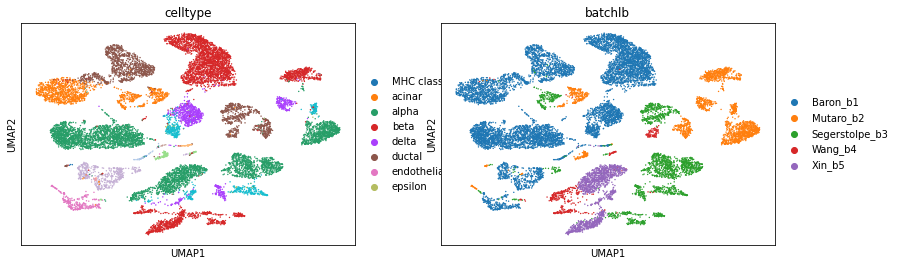

In [67]:
color_group = ["celltype", "batchlb"]
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=color_group)

In [73]:
corr = bbknn.bbknn(adata, copy=True, neighbors_within_batch=5, trim=0, n_pcs=20, batch_key="batchlb")

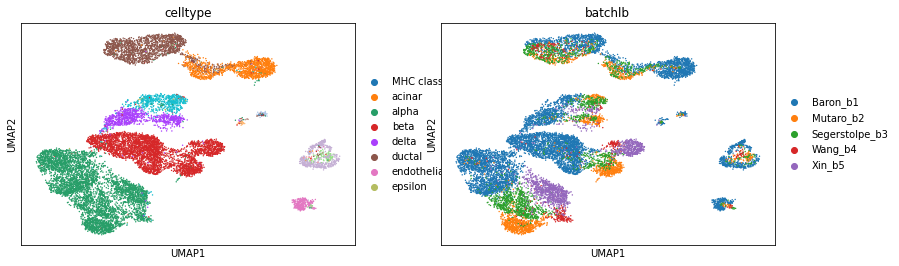

In [74]:
color_group = ["celltype", "batchlb"]
# sc.pp.neighbors(corr, n_neighbors=10, n_pcs=20)
sc.tl.umap(corr)
sc.pl.umap(corr, color=color_group)